In [16]:
import numpy as np, pandas as pd, seaborn as sns, tensorflow as tf, warnings
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings('ignore')

In [2]:
sns.set(style = 'whitegrid')
plt.rc('figure', autolayout = True)
plt.rc('axes', labelweight = 'bold', labelsize = 'large', titleweight = 'bold', titlesize = 18, titlepad = 10)
plt.rc('animation', html = 'html5')

In [3]:
def classify_health_impact(score):
    if score >= 80:
        return 0  
    elif score >= 60:
        return 1  
    elif score >= 40:
        return 2  
    elif score >= 20:
        return 3  
    else:
        return 4  

In [4]:
air = pd.read_csv('air_quality_health_impact_data.csv')
air_cleaned = air.drop(columns = ['RecordID'])
for col in ['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3']:
    Q1 = air_cleaned[col].quantile(0.25)
    Q3 = air_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    air_cleaned[col] = air_cleaned[col].apply(lambda x: min(max(x, lower_bound), upper_bound))
air_cleaned['HealthImpactClass'] = air_cleaned['HealthImpactScore'].apply(classify_health_impact)

In [10]:
y = air_cleaned['HealthImpactClass']
x = air_cleaned.drop(['HealthImpactClass', 'HealthImpactScore'], axis = 1)
scaler = StandardScaler()
x = scaler.fit_transform(x)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 52)
ytrain = to_categorical(ytrain, num_classes = 5)
ytest = to_categorical(ytest, num_classes = 5)

In [7]:
model = Sequential([
    Dense(64, input_shape = (x.shape[1], ), activation = relu),  
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation = relu),     
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation = relu),     
    BatchNormalization(),
    Dense(5, activation = softmax)                         
])

In [11]:
model.compile(optimizer = Adam(), loss = CategoricalCrossentropy(), metrics = ['accuracy'])
history = model.fit(xtrain, ytrain, epochs = 100, batch_size = 64, validation_split = 0.2, verbose = 2)

Epoch 1/100
51/51 - 9s - 170ms/step - accuracy: 0.3342 - loss: 1.7490 - val_accuracy: 0.8305 - val_loss: 1.1492
Epoch 2/100
51/51 - 0s - 9ms/step - accuracy: 0.6179 - loss: 1.1294 - val_accuracy: 0.8784 - val_loss: 0.7882
Epoch 3/100
51/51 - 1s - 10ms/step - accuracy: 0.8014 - loss: 0.7648 - val_accuracy: 0.8968 - val_loss: 0.5131
Epoch 4/100
51/51 - 0s - 9ms/step - accuracy: 0.8721 - loss: 0.5157 - val_accuracy: 0.9042 - val_loss: 0.3693
Epoch 5/100
51/51 - 0s - 10ms/step - accuracy: 0.8989 - loss: 0.3769 - val_accuracy: 0.9091 - val_loss: 0.2884
Epoch 6/100
51/51 - 0s - 9ms/step - accuracy: 0.9041 - loss: 0.3099 - val_accuracy: 0.9165 - val_loss: 0.2490
Epoch 7/100
51/51 - 1s - 13ms/step - accuracy: 0.9078 - loss: 0.2631 - val_accuracy: 0.9300 - val_loss: 0.2123
Epoch 8/100
51/51 - 0s - 9ms/step - accuracy: 0.9109 - loss: 0.2465 - val_accuracy: 0.9337 - val_loss: 0.1948
Epoch 9/100
51/51 - 0s - 10ms/step - accuracy: 0.9188 - loss: 0.2155 - val_accuracy: 0.9287 - val_loss: 0.1832
Epoc

In [12]:
test_loss, test_accuracy = model.evaluate(xtest, ytest, verbose = 0)
print(f'Test Accuracy: {test_accuracy:.4f}')
ypred = (model.predict(xtest) > 0.5).astype("int32")

Test Accuracy: 0.9805
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


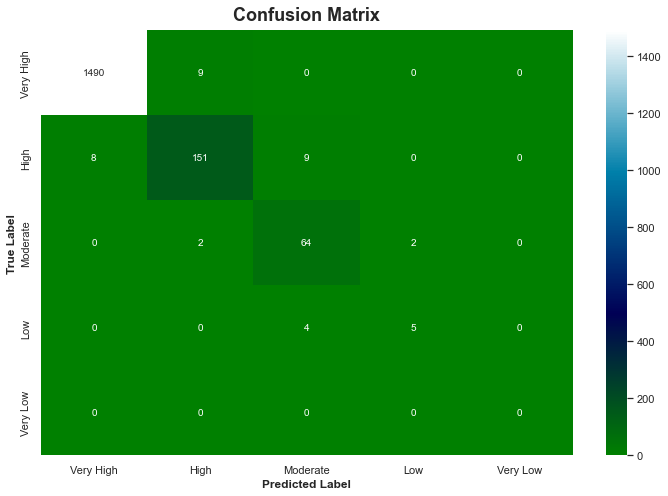

In [18]:
plt.figure(figsize=(10, 7))
ypred = model.predict(xtest)
ypred_classes = np.argmax(ypred, axis = 1) 
ytrue_classes = np.argmax(ytest, axis = 1) 
class_labels = ['Very High', 'High', 'Moderate', 'Low', 'Very Low']
sns.heatmap(confusion_matrix(ytrue_classes, ypred_classes, labels = [0, 1, 2, 3, 4]), annot = True, fmt = 'd', cmap = 'ocean', xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
print(classification_report(ytrue_classes, ypred_classes))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1499
           1       0.93      0.90      0.92       168
           2       0.83      0.94      0.88        68
           3       0.71      0.56      0.62         9

    accuracy                           0.98      1744
   macro avg       0.87      0.85      0.85      1744
weighted avg       0.98      0.98      0.98      1744

